# Peru Minimum Temperature (Tmin) Raster Analysis

In [61]:
import os
import geopandas as gpd
import rasterio
import unicodedata
import numpy as np
import pandas as pd
from rasterio.mask import mask
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import seaborn as sns

### 1. Data

##### 1.1 Districts shapefile

In [10]:
shapefile_path = os.path.join("C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/Sesion 7/shape_file", "DISTRITOS.shp")
distritos = gpd.read_file(shapefile_path)
distritos.head(5)

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."


In [8]:
# Limpiar que el nombre del distrito está en mayúsculas y no tiene diacríticos
def limpiar_nombre(texto):
    if not isinstance(texto, str):
        return texto
    # Eliminar diacríticos (acentos, etc.)
    texto_normalizado = unicodedata.normalize('NFD', texto)
    texto_sin_diacriticos = ''.join(
        c for c in texto_normalizado if unicodedata.category(c) != 'Mn'
    )
    # Convertir a mayúsculas
    return texto_sin_diacriticos.upper()

In [9]:
# Aplicar transformación
distritos['DISTRITO'] = distritos['DISTRITO'].apply(limpiar_nombre)

##### 1.2 Tmin GeoTIFF

In [44]:
# Ruta al archivo
archivo = "C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/TAREA 3/tmin_raster.tif"

# Abrir el archivo
with rasterio.open(archivo) as src:
    print("Ancho:", src.width)
    print("Alto:", src.height)
    print("Número de bandas:", src.count)
    print("Sistema de coordenadas:", src.crs)
    print("Transformación (afín):", src.transform)

# Leer los datos de las bandas
    banda1 = src.read(1)
    banda2 = src.read(2)
    banda3 = src.read(3)
    banda4 = src.read(4)
    banda5 = src.read(5)

Ancho: 285
Alto: 397
Número de bandas: 5
Sistema de coordenadas: EPSG:4326
Transformación (afín): | 0.05, 0.00,-81.38|
| 0.00,-0.05, 1.20|
| 0.00, 0.00, 1.00|


### 2. Zonal statistics

In [45]:
# Verificar la escala de los valores
print("Valor mínimo - Banda 1:", np.nanmin(banda1))
print("Valor máximo - Banda 1:", np.nanmax(banda1))
print("Valor mínimo - Banda 2:", np.nanmin(banda2))
print("Valor máximo - Banda 2:", np.nanmax(banda2))
print("Valor mínimo - Banda 3:", np.nanmin(banda3))
print("Valor máximo - Banda 3:", np.nanmax(banda3))
print("Valor mínimo - Banda 4:", np.nanmin(banda4))
print("Valor máximo - Banda 4:", np.nanmax(banda4))
print("Valor mínimo - Banda 5:", np.nanmin(banda5))
print("Valor máximo - Banda 5:", np.nanmax(banda5))

Valor mínimo - Banda 1: -9.052621
Valor máximo - Banda 1: 24.636774
Valor mínimo - Banda 2: -10.024566
Valor máximo - Banda 2: 24.390877
Valor mínimo - Banda 3: -9.866587
Valor máximo - Banda 3: 24.213442
Valor mínimo - Banda 4: -9.062276
Valor máximo - Banda 4: 24.123045
Valor mínimo - Banda 5: -8.848353
Valor máximo - Banda 5: 24.146505


Los datos de temperatura que se tienen no requieren ser reescalados.

##### Visualización de las 5 bandas

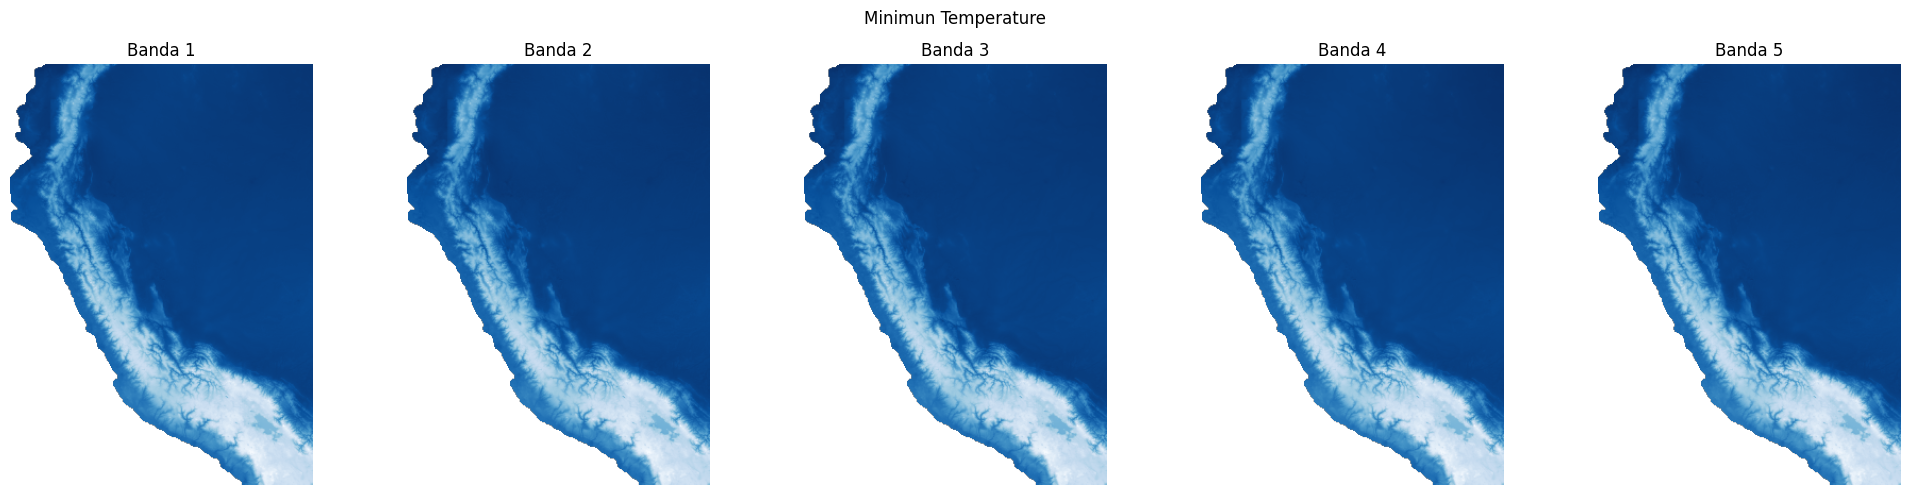

In [53]:
nombre_columna = "DISTRITO"

# Visualizar el ráster original
with rasterio.open("C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/TAREA 3/tmin_raster.tif") as src:
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(1, 6):
        banda = src.read(i)
        axs[i-1].imshow(banda, cmap="Blues")
        axs[i-1].set_title(f"Banda {i}")
        axs[i-1].axis("off")
    plt.suptitle("Minimun Temperature")
    plt.tight_layout()
    plt.show()

#### Clipping with data of Peru

In [47]:
# Reproyectar shapefile si es necesario (para que coincida con el raster)
with rasterio.open("C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/TAREA 3/tmin_raster.tif") as src:
    if distritos.crs != src.crs:
        distritos = distritos.to_crs(src.crs)
    
    # Recortar el raster usando el shapefile
    out_image, out_transform = mask(src, distritos.geometry, crop=True)
    out_meta = src.meta.copy()

# Actualizar metadata para el nuevo raster recortado
out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Guardar el nuevo raster recortado (opcional)
with rasterio.open("recorte.tif", "w", **out_meta) as dest:
    dest.write(out_image)

##### Recorte del ráster completo a Perú usando los distritos

In [52]:
# Abrir y recortar todas las bandas del ráster
with rasterio.open("C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/TAREA 3/tmin_raster.tif") as src:
    out_image, out_transform = mask(src, distritos.geometry, crop=True)
    out_meta = src.meta.copy()

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Guardar el nuevo ráster recortado
with rasterio.open("Prec_raster_peru.tif", "w", **out_meta) as dest:
    dest.write(out_image)

 ##### Temperatura promedio en cada distrito a lo largo del tiempo

In [74]:
# Definir las estadísticas a calcular
estadisticas = ["count", "mean", "min", "max", "std", "percentile_10", "percentile_90", "median"]

# Calcular estadísticas zonales por banda
promedios = []
for b in range(1, 6): # el 6 no lo cuenta
    stats = zonal_stats(distritos, "C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/TAREA 3/tmin_raster.tif", stats=estadisticas, band=b)

# Agregar cada métrica como una columna nueva al GeoDataFrame
    for stat in estadisticas:
        distritos[f"banda{b}_{stat}"] = [s.get(stat, None) for s in stats]

# Calcular promedio de medias de las 5 bandas
distritos["tmin_mean_total"] = distritos[[f"banda{b}_mean" for b in range(1, 6)]].mean(axis=1)

# Mostrar resultados con los nombres de distritos
print(distritos[["DISTRITO", "tmin_mean_total"]].head())

                 DISTRITO  tmin_mean_total
0         CODO DEL POZUZO        18.761000
1             TOURNAVISTA        22.048223
2  ALEXANDER VON HUMBOLDT        21.862907
3                 IRAZOLA        22.097315
4                 NESHUYA        21.937903


### 3. Zonal statistics

##### Distribution: histogram/KDE of district-level mean Tmin.

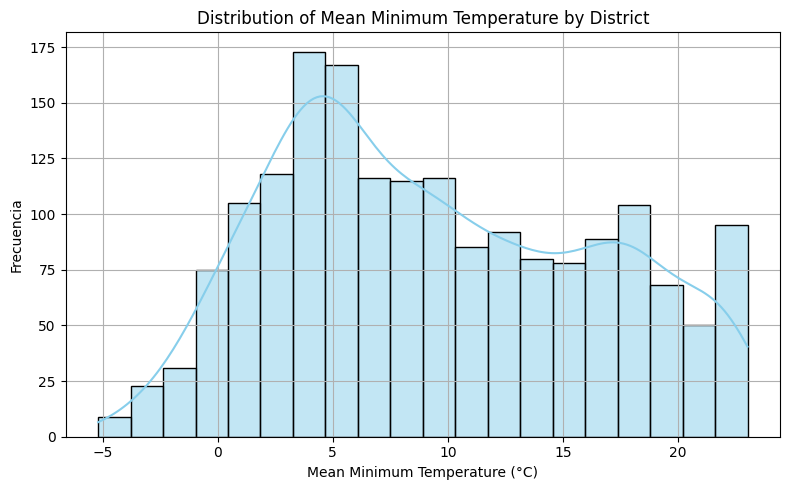

In [113]:
# Eliminar NaN
data = distritos["tmin_mean_total"].dropna()

# Crear figura
plt.figure(figsize=(8, 5))
sns.histplot(data, kde=True, bins=20, color='skyblue', edgecolor='black')

plt.title("Distribution of Mean Minimum Temperature by District")
plt.xlabel("Mean Minimum Temperature (°C)")
plt.ylabel("Frecuencia")
plt.grid(True)

plt.tight_layout()

# Guardar el mapa como PNG
plt.savefig("C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/TAREA 3/histogram_tmin_mean_total.png", dpi=300, bbox_inches='tight')

##### Ranking: Top 15 districts with lowest mean Tmin (frost risk) and top 15 highest

In [108]:
# Eliminar NaN
data = distritos.dropna(subset=["tmin_mean_total"])

# Top 15 districts with lowest mean Tmin
top15_lowest = data.sort_values(by="tmin_mean_total", ascending=True).head(15)

print("Top 15 districts with lowest mean Tmin (frost risk):")
print(top15_lowest[["DISTRITO", "tmin_mean_total"]])

# Exportar a CSV
top15_lowest[["DISTRITO", "tmin_mean_total"]].to_csv("top15_lowest_tmin.csv", index=False)

Top 15 districts with lowest mean Tmin (frost risk):
                 DISTRITO  tmin_mean_total
60                 CAPAZO        -5.191071
56               SUSAPAYA        -5.157803
49                 TARATA        -4.995736
79             SANTA ROSA        -4.861880
51                 TICACO        -4.417395
163  SAN ANTONIO DE CHUCA        -4.390306
61              CANDARAVE        -4.359307
801             CONDOROMA        -4.122947
525               PARATIA        -4.094575
83                CARUMAS        -3.411975
137  SAN JUAN DE TARUCANI        -3.343182
186                  TUTI        -3.258119
66               PISACOMA        -3.248725
368               AJOYANI        -3.141027
192           SANTA LUCIA        -3.063950


In [109]:
# Top 15 districts with highest mean Tmin
top15_highest = data.sort_values(by="tmin_mean_total", ascending=False).head(15)

print("Top 15 districts with highest mean Tmin:")
print(top15_highest[["DISTRITO", "banda5_mean"]])

# Exportar a CSV
top15_highest[["DISTRITO", "tmin_mean_total"]].to_csv("top15_highest_tmin.csv", index=False)

Top 15 districts with highest mean Tmin:
            DISTRITO  banda5_mean
1680          MORONA    22.952683
1835          YAGUAS    22.973618
1676  RAMON CASTILLA    22.926581
1675       SAN PABLO    22.887480
1677         PASTAZA    22.870794
1679           PEBAS    22.836467
1678    LAS AMAZONAS    22.762101
560          IQUITOS    22.722595
680         PUTUMAYO    22.742786
1666         INDIANA    22.698646
615           YAVARI    22.686692
738          LAGUNAS    22.694448
1668        PUNCHANA    22.665260
1672           NAUTA    22.622309
739         URARINAS    22.645240


##### Map: static choropleth

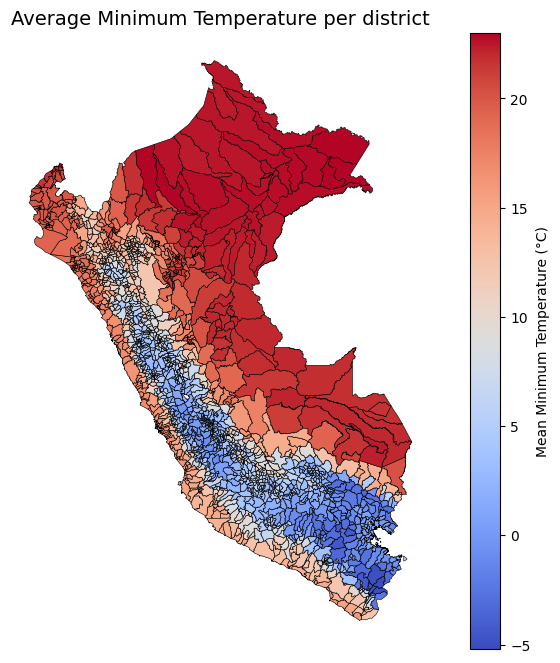

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
distritos.plot(
    column="tmin_mean_total",
    cmap="coolwarm", # azul = frío, rojo = cálido
    linewidth=0.4,
    edgecolor='black',
    legend=True,
    legend_kwds={"label": "Mean Minimum Temperature (°C)"},
    ax=ax
)

ax.set_axis_off()
ax.set_title("Average Minimum Temperature per district", fontsize=14)

# Guardar el mapa como PNG
plt.savefig("C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/TAREA 3/mapa_tmin_mean_total.png", dpi=300, bbox_inches='tight')

# Guardar tabla de datos como CSV
distritos[["DISTRITO", "tmin_mean_total"]].to_csv("C:/Users/Carla HL/Desktop/DIPLOMATURA Q-LAB/PYTHON INTERMEDIO/TAREA 3/tabla_tmin_districts.csv", index=False)

### 4. Public policy